# Setup

In [2]:
import os
import string
import praw
from dotenv import load_dotenv
import json
from top2vec import Top2Vec
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import re
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sentence_transformers import SentenceTransformer
import os
import tensorflow as tf
import tensorflow_hub as hub



# Load variables from .env
load_dotenv()
client_id = os.getenv('REDDIT_CLIENT_ID')
client_secret = os.getenv('REDDIT_CLIENT_SECRET')
user_agent = os.getenv("REDDIT_USER_AGENT")


# Set up the Reddit instance
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
)
# Define the subreddit you want to download from
subreddit = reddit.subreddit('ClashOfClans')

/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-15 18:16:13.812160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 18:16:15.136566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Processing functions

In [3]:
# Downloading necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initializations
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs, punctuations and special characters and numbers
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    # Remove special words
    words_to_remove = ['supercell', 'coc']
    removal_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words_to_remove) + r')\b'
    text = re.sub(removal_pattern, '', text)

    tokens = word_tokenize(text)  # Tokenization
    # Remove stopwords and lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    text = ' '.join(tokens)
    return text

# Test
sample_text = "This is a sample sentence, containing URLs https://www.example.com and numbers 12345."
print(preprocess(sample_text))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ilarivp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ilarivp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ilarivp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


sample sentence containing url number


In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
def print_topics(model):
    topic_words, word_scores, topic_nums = model.get_topics()

    for idx, topic in enumerate(topic_nums):
        print(f"Topic {idx + 1}")
        print("-------------------")
        for word, score in zip(topic_words[idx], word_scores[idx]):
            print(word, "(Score:", score,")")
        print("\n")


def preprocess_new(text):
    # Tokenize, remove punctuation, lowercase, remove stopwords
    tokens = word_tokenize(text)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

def compute_coherence_for_top2vec(model, use_preprocess = False, coherence_model = 'u_mass'):
    """
    Good explanation: https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c
    """

    # Preprocess documents
    if use_preprocess:
        texts = [preprocess_new(doc) for doc in model.documents]
    else:
        texts = [word_tokenize(doc) for doc in model.documents]

    # Create a Gensim dictionary from the preprocessed documents
    dictionary = Dictionary(texts)

    # Get topic words
    topic_nums = model.get_num_topics()
    topic_words, word_scores, topic_nums = model.get_topics(topic_nums)

    # Compute coherence for each topic
    # coherences = []
    # for words in topic_words:
    #     cm = CoherenceModel(topics=[words], texts=texts, dictionary=dictionary, coherence=coherence_model)
    #     coherences.append(cm.get_coherence())
    cm = CoherenceModel(topics=topic_words, texts=texts, dictionary=dictionary, coherence=coherence_model)
    coherences = cm.get_coherence_per_topic()
    return coherences

def compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents, document_topics = None, document_embeddings = None):
    """
    Compute the silhouette score for a given Top2Vec model.

    Parameters:
    - model: The trained Top2Vec model
    - model_to_use: The embedding model identifier for SentenceTransformer
    - preprocessed_documents: A list of preprocessed documents for embedding encoding

    Returns:
    - Silhouette score if there are multiple labels, or a message indicating there's only one label
    """

    # Retrieve document topics
    if document_topics is None:
        document_topics = model.get_documents_topics([i for i in range(len(model.documents))])[0]
    if document_embeddings is None:
        document_embeddings = model.document_vectors

    # Convert topic scores to labels for silhouette scoring
    labels = document_topics

    # Calculate and return the silhouette score or a relevant message
    if len(set(labels)) > 1:
        silhouette = silhouette_score(document_embeddings, labels)
        return silhouette
    else:
        return "Cannot compute silhouette score for a single label"

def get_embeddings(texts, model, batch_size=32):
    """Get embeddings for a list of texts, processing in batches."""
    embeddings = []
    # Process texts in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = model(batch_texts)
        embeddings.append(batch_embeddings)
    # Concatenate all batch embeddings together
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings


# Topic modeling using comment chains as documents

## Load comment chains

In [93]:
from datetime import datetime


def get_comment_chain(comment):
    chain_text = comment.body
    chain_timestamps = [datetime.utcfromtimestamp(comment.created_utc)]
    for reply in comment.replies:
        reply_text, reply_timestamps = get_comment_chain(reply)
        chain_text += '\n' + reply_text
        chain_timestamps.extend(reply_timestamps)
    return chain_text, chain_timestamps

data = []

# Download posts
for submission in subreddit.search("flair:Discussion", sort='hot', limit=500):
    post_data = {
        "title": submission.title,
        "selftext": submission.selftext,
        "timestamp": datetime.utcfromtimestamp(submission.created_utc),
        "comment_chains": []
    }

    # Download comments from the current post
    submission.comments.replace_more(limit=None)  # Fetch more comments if needed
    for comment in submission.comments:
        comment_chain_text, comment_chain_timestamps = get_comment_chain(comment)
        comment_chain_data = {
            "text": comment_chain_text,
            "timestamps": comment_chain_timestamps
        }
        post_data["comment_chains"].append(comment_chain_data)

    data.append(post_data)

date_string = datetime.now().strftime("%Y%m%d")
# Save the collected data to a JSON file
with open(f'reddit_data_comment_chain_{date_string}.json', 'w') as f:
    json.dump(data, f, indent=4, default=str)  # Add default=str to handle datetime objects

In [8]:
from datetime import datetime
# Load the collected data from the JSON file
date_string = datetime.now().strftime("%Y%m%d")
with open(f'reddit_data_comment_chain_{date_string}.json', 'r') as f:
    data = json.load(f)

documents = []
timestamps = []  # List to store the timestamp of the first comment in each comment chain

# Process the data into documents for topic modeling
for post in data:
    for comment_chain in post['comment_chains']:
        combined_text = post['title'] + ' ' + post['selftext'] + ' ' + comment_chain['text']
        # Each comment chain is treated as a separate document
        documents.append(combined_text)
        # Capture the timestamp of the first comment in the comment chain
        if comment_chain['timestamps']:  # Check if the timestamps list is not empty
            timestamps.append(comment_chain['timestamps'][0])

In [9]:
documents

["Why does the tesla upgrade time gofrom 3 days to almost 8? This shit hurts me man Yeah th12 is the first time we start getting these long timer but don't worry it gets worse <3\nTH12 is the first bottleneck. TH14 is the second bottleneck. I think currently, an f2p player can make it to TH14 relatively easily. After that though, it becomes much much harder to play as an f2p player.\nI'm doing th16 as a non-rushed ftp and I agree it's been hell\nHonestly I'm surprised you were even able to make it TH16. I've been playing this game since 2015 or so and I've taken several breaks over the years because I just get so burnt out whenever I see those 14 day upgrade timers. \n\nThankfully, the recent time reductions made TH12 much easier and now I've upgraded to TH13 about 1.5 months ago. Let's see how long I can go before I get burnt out lol.\nBeen playing since 2013, I don't get burnt out because I only play aspects of the game that I like. It's mostly cwl and sometimes I feel motivated enou

## Topic model

You can find more details on topic model here: 
https://github.com/ddangelov/Top2Vec?tab=readme-ov-file

In [16]:
use_preprocess = False
if use_preprocess:
    preprocessed_documents = [preprocess(doc) for doc in documents]  # preprocess documents
    preprocessed_documents = [doc for doc in preprocessed_documents if doc.strip()]  # Remove empty documents (such as emojis)
else:
    preprocessed_documents = [doc for doc in documents if doc.strip()]  # Remove possible empty documents

umap_args = {
    'n_neighbors': 30,  # Increase for boarder 
    'n_components': 10,  # Amount of dimensions to reduce
    'metric': 'cosine'  # Similarity metric
}


hdbscan_args = {
    'min_cluster_size': 50,  # Increase for larger clusters
    'min_samples': 10,  # Increase for larger clusters
    'metric': 'euclidean', 
    'cluster_selection_method': 'eom'  # Excess of Mass
}


# doc2vec
# universal-sentence-encoder
# universal-sentence-encoder-large
# universal-sentence-encoder-multilingual
# universal-sentence-encoder-multilingual-large
# distiluse-base-multilingual-cased
# all-MiniLM-L6-v2
# paraphrase-multilingual-MiniLM-L12-v2
model_to_use = 'universal-sentence-encoder-large'

model = Top2Vec(
    preprocessed_documents,
    min_count = 80,
    embedding_model=model_to_use,
    workers=4,
    umap_args=umap_args,
    hdbscan_args=hdbscan_args,
    embedding_batch_size = 18
)

topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)

2024-02-15 18:23:27,720 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-02-15 18:23:28,641 - top2vec - INFO - Downloading universal-sentence-encoder-large model
INFO:top2vec:Downloading universal-sentence-encoder-large model
2024-02-15 18:23:40,753 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-02-15 18:24:25,319 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-02-15 18:24:33,507 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-02-15 18:24:33,651 - top2vec - INFO - Finding topics
INFO:

[309 293 251 243 227 211 197 185 177 174 169 160 153 150 141 141 133 132
 130 124 116 114 112 112 105  97  94  85  82  81  75  67  67  67  67  66
  62  62  59  58  57  57  53]


## Analyze topics

I suggest reading about coherence scores from article: 
https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

![Model coherence calculation](https://miro.medium.com/v2/resize:fit:720/format:webp/1*9rH9c-VJ3K27Q__wulDNvA.png)

In short: 
1. Segment words in topic into pairs
2. Calculate probability of occurence of word & pair of words (different techniques estimate these probabilities differently)
3. Calculate confirmation measure
4. Aggregate confirmation measure into single coherence score.


![Model cohrence short](https://miro.medium.com/v2/resize:fit:720/format:webp/1*UGvSTgQeW6vOvlB4c5NhUg.png)


In [17]:
# Calculate metrics for topics
coherences = compute_coherence_for_top2vec(model, use_preprocess, coherence_model='c_npmi') # u_mass, c_v, c_uci, c_npmi
for idx, coherence in enumerate(coherences):
    print(f"Topic {idx}, Coherence Score: {coherence.round(4)}")
average_coherence = sum(coherences) / len(coherences)
print(f"Average Coherence Score: {average_coherence.round(4)}")

silhouette = compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents)
print(f"Silhouette Score: {str(silhouette.round(4))}")

Topic 0, Coherence Score: -0.3451
Topic 1, Coherence Score: -0.3438
Topic 2, Coherence Score: -0.3308
Topic 3, Coherence Score: -0.2581
Topic 4, Coherence Score: -0.37
Topic 5, Coherence Score: -0.2211
Topic 6, Coherence Score: -0.2914
Topic 7, Coherence Score: -0.3671
Topic 8, Coherence Score: -0.3039
Topic 9, Coherence Score: -0.3488
Topic 10, Coherence Score: -0.3781
Topic 11, Coherence Score: -0.3144
Topic 12, Coherence Score: -0.3691
Topic 13, Coherence Score: -0.2816
Topic 14, Coherence Score: -0.3308
Topic 15, Coherence Score: -0.3248
Topic 16, Coherence Score: -0.3792
Topic 17, Coherence Score: -0.3028
Topic 18, Coherence Score: -0.3168
Topic 19, Coherence Score: -0.3285
Topic 20, Coherence Score: -0.3556
Topic 21, Coherence Score: -0.2173
Topic 22, Coherence Score: -0.36
Topic 23, Coherence Score: -0.3546
Topic 24, Coherence Score: -0.3511
Topic 25, Coherence Score: -0.3668
Topic 26, Coherence Score: -0.3383
Topic 27, Coherence Score: -0.4093
Topic 28, Coherence Score: -0.3415

# Visualizations

### UMAP projection of topics

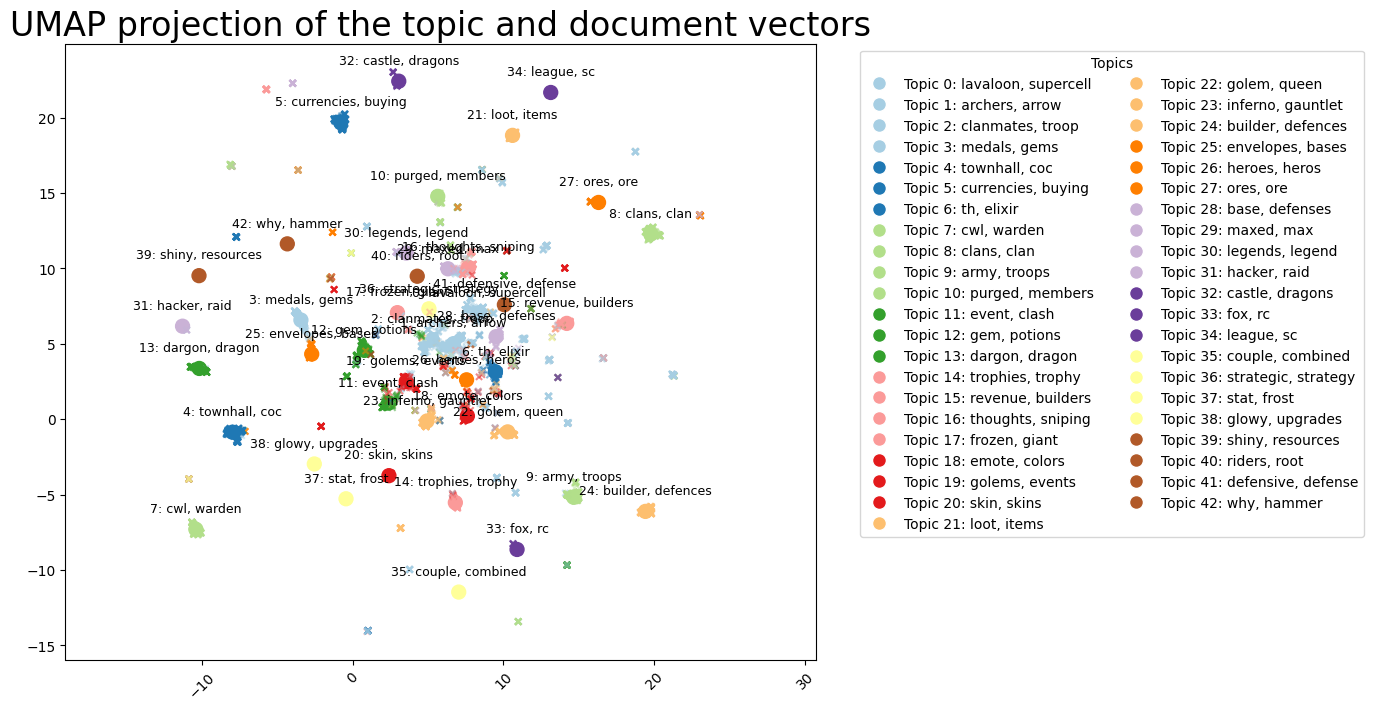

In [18]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


# Function to get two unique top words for each topic
def get_top_words(words, n_words = 2, used_words = set()):
    # Create a set to keep track of already used words
    top_words = []
    for word in words:
        if word not in used_words:
            top_words.append(word)
            used_words.add(word)
        if len(top_words) == n_words:
            break
    return (', '.join(top_words), used_words)

# Get topics and top words per topic
topic_weights, topic_nums = model.get_topic_sizes()
topic_vectors = model.topic_vectors
topic_words, word_scores, _ = model.get_topics()
used_words = set()
top_words = []
for topic in topic_words:  # Get two top words for each topic
    words, used_words = get_top_words(words=topic, n_words=2, used_words = used_words)
    top_words.append(words)  
document_vectors = model.document_vectors  # Get document vectors and document topics
document_topics = model.doc_top  # Topic assignments to each document

# Create a unique color for each topic number
unique_topics = np.unique(document_topics)
colors = plt.cm.Paired(np.linspace(0, 1, len(unique_topics))) 
colormap = ListedColormap(colors)


# UMAP #
all_vectors = np.vstack([topic_vectors, document_vectors])  # Combine and transform at the same time
reducer = umap.UMAP(init='random')
embedding = reducer.fit_transform(all_vectors)
# Split the embeddings back into topics and documents
topic_embedding = embedding[:len(topic_vectors)]
document_embedding = embedding[len(topic_vectors):]

# Plotting # 
topic_colors = colormap(unique_topics / max(unique_topics))  # Prepare the colors
# Create a figure and axis object, which gives more control over the plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(topic_embedding[:, 0], topic_embedding[:, 1], s=100, c=topic_colors, alpha=1, label='Topics')
ax.scatter(document_embedding[:, 0], document_embedding[:, 1], s=20, alpha=0.5, c=document_topics, cmap=colormap, marker='x', label='Documents')

# Create custom labels for the legend
custom_labels = [f"Topic {num}: {word}" for num, word in zip(topic_nums, top_words)]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=colormap(i / max(unique_topics))) for i, label in enumerate(custom_labels)]

# Adjust legend position
legend1 = plt.legend(handles=legend_handles, title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=(len(custom_labels) + 14) // 20)
# Annotate each topic number along with the top words from the topic
for i, num in enumerate(topic_nums):
    annotation = f"{num}: {top_words[i]}"
    plt.annotate(
        annotation, 
        (topic_embedding[i, 0], topic_embedding[i, 1]), 
        fontsize=9, 
        ha='center', 
        va='bottom',  # align the bottom of the text
        xytext=(0, 10),  # shift text 10 points upward
        textcoords='offset points'
    )

ax.set_aspect('equal', 'datalim')
ax.set_title('UMAP projection of the topic and document vectors', fontsize=24)
plt.xticks(rotation=45)

# Adjust layout to make space for the legend
plt.subplots_adjust(right=0.75)
plt.show()


### Plot over time

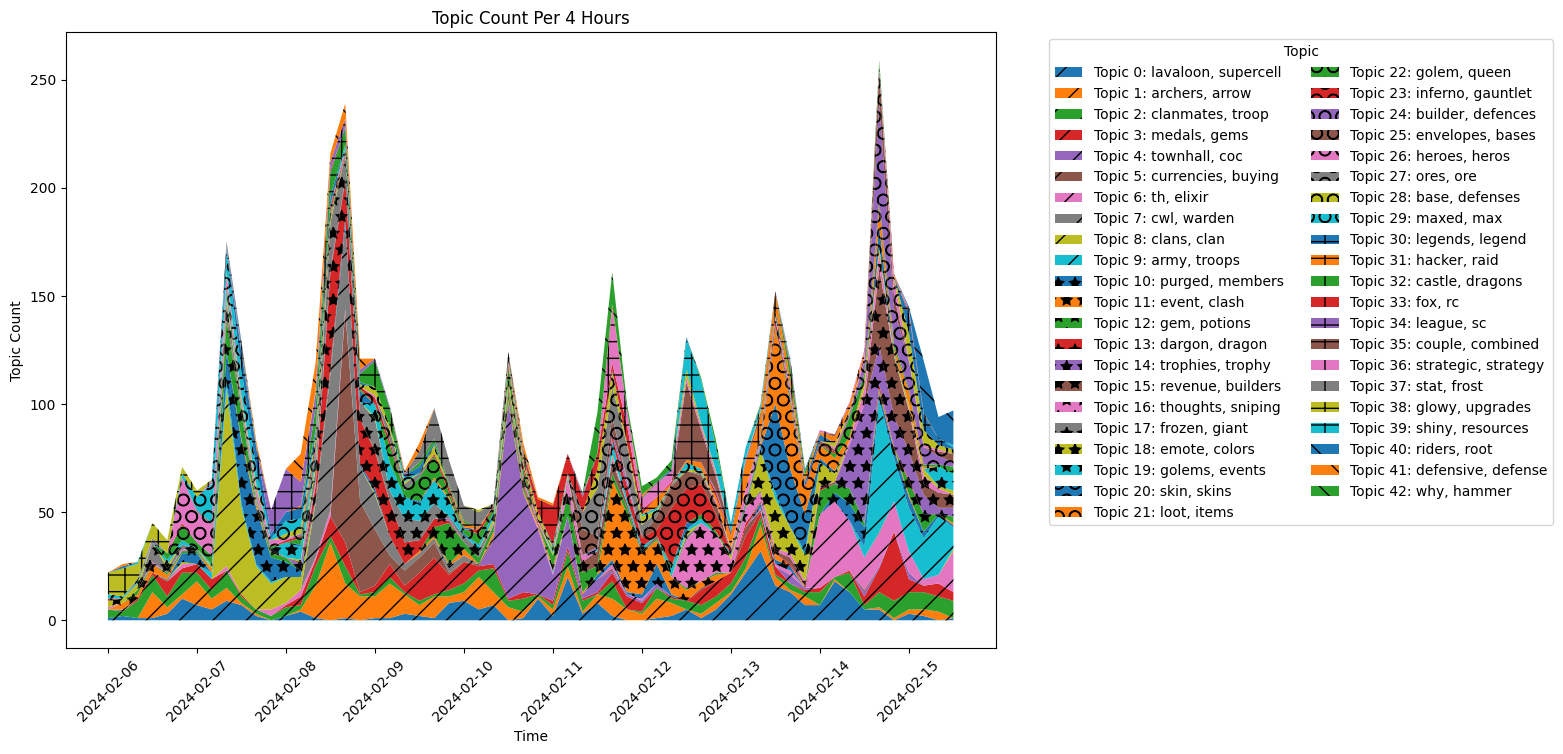

In [19]:
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import pandas as pd


data_dict = defaultdict(lambda: defaultdict(int))  # Nested dictionary to hold counts
for topic, timestamp in zip(model.doc_top, timestamps):
    timestamp_dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
    data_dict[timestamp_dt][topic] += 1  # Use the datetime object as the key

data_df = pd.DataFrame(data_dict).T.fillna(0)  # Convert the nested dictionary to a pandas DataFrame
data_df.index = pd.to_datetime(data_df.index)  # Convert the index to datetime objects
data_df.sort_index(inplace=True)  # Sort the DataFrame by the index

data_df = data_df.resample('4H').sum()  # use 4h interval

# Sort the columns (topics) alphabetically before plotting
data_df = data_df.sort_index(axis=1)
topic_words, word_scores, _ = model.get_topics()

# Get two top words for each topic
used_words = set()
top_words = []
for topic in topic_words:  # Get two top words for each topic
    words, used_words = get_top_words(words=topic, n_words=2, used_words = used_words)
    top_words.append(words)  
new_col_names = [
    f'Topic {topic_num}: {topic_word}'
    for topic_num, topic_word in enumerate(top_words)
]

data_df.columns = new_col_names

# Get cumulative sum for stacking
data_cum = data_df.cumsum(axis=1)
fig, ax = plt.subplots(figsize=(12,8))

# Define hatch patterns
hatches_patterns = ['/', '*', 'O', '+', '\\', 'x', 'o', '|', '-', '.']
# Ensure there are enough hatches by repeating the pattern
hatches = hatches_patterns * ((len(data_df.columns) // len(hatches_patterns)) + 1)

# Plot each area separately with its own hatch pattern
for i, col in enumerate(data_df.columns):
    hatch_group = i // 10  # Determine which group of 10 the current topic falls into
    hatch_index = hatch_group % len(hatches_patterns)  # Get the index of the hatch pattern to use
    hatch = hatches_patterns[hatch_index]  # Get the hatch pattern
    if i == 0:
        ax.fill_between(data_df.index, 0, data_cum[col], hatch=hatch, label=col)
    else:
        ax.fill_between(data_df.index, data_cum.iloc[:, i - 1], data_cum[col], hatch=hatch, label=col)

plt.xlabel('Time')
plt.ylabel('Topic Count')
plt.title('Topic Count Per 4 Hours')

# Move legend to upper right outside the plot area and sort topics alphabetically
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=(len(data_df.columns) + 14) // 20)
# Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()

### Word clouds

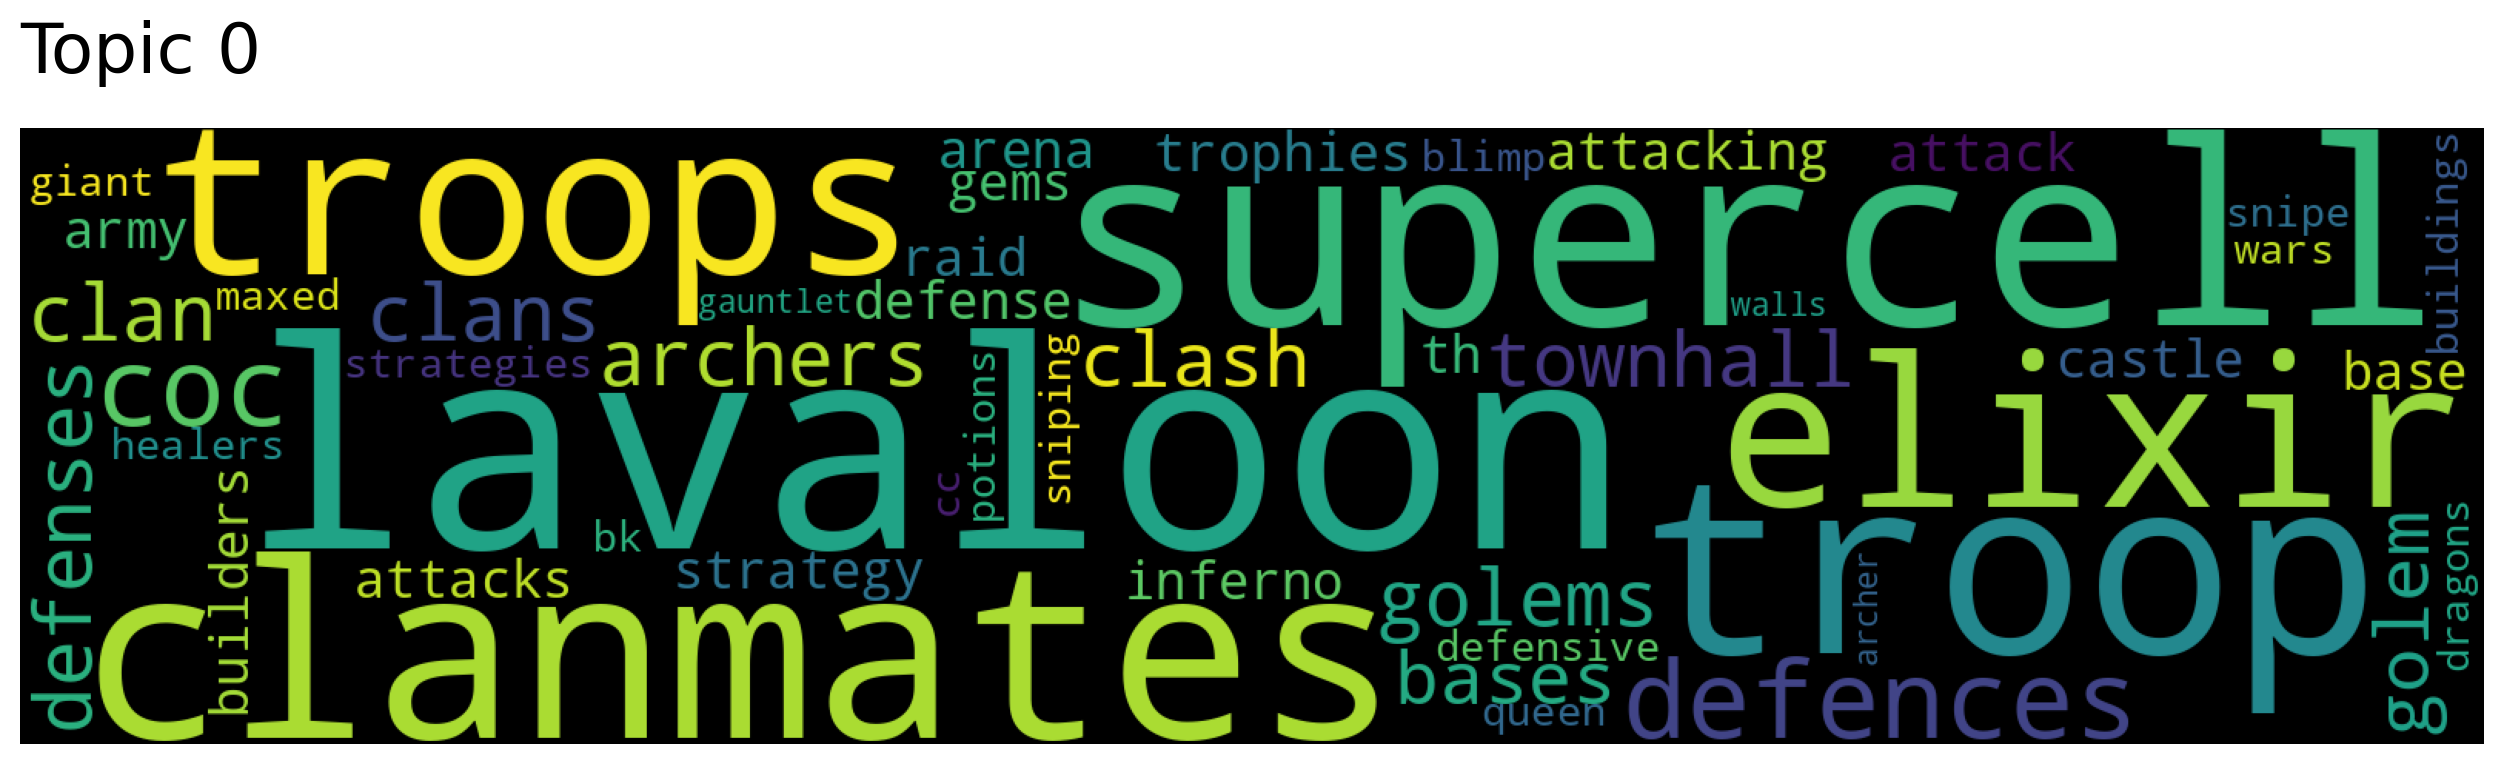

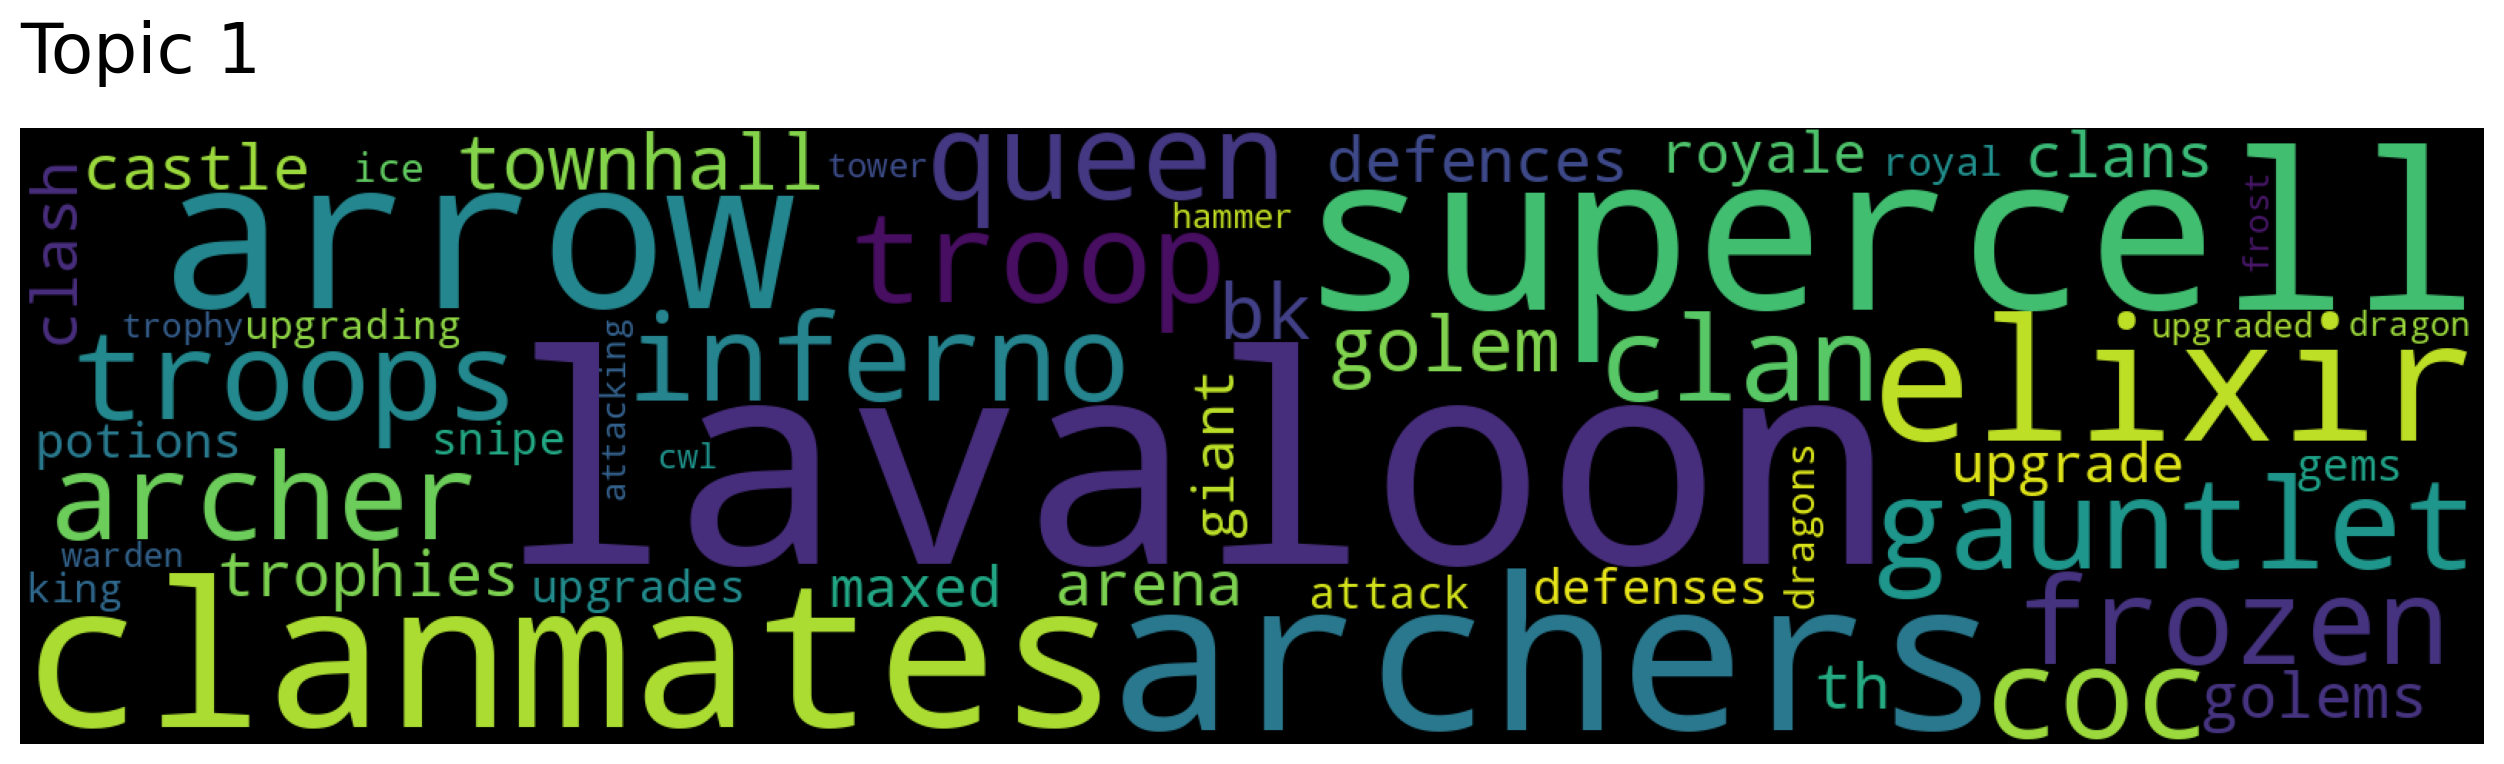

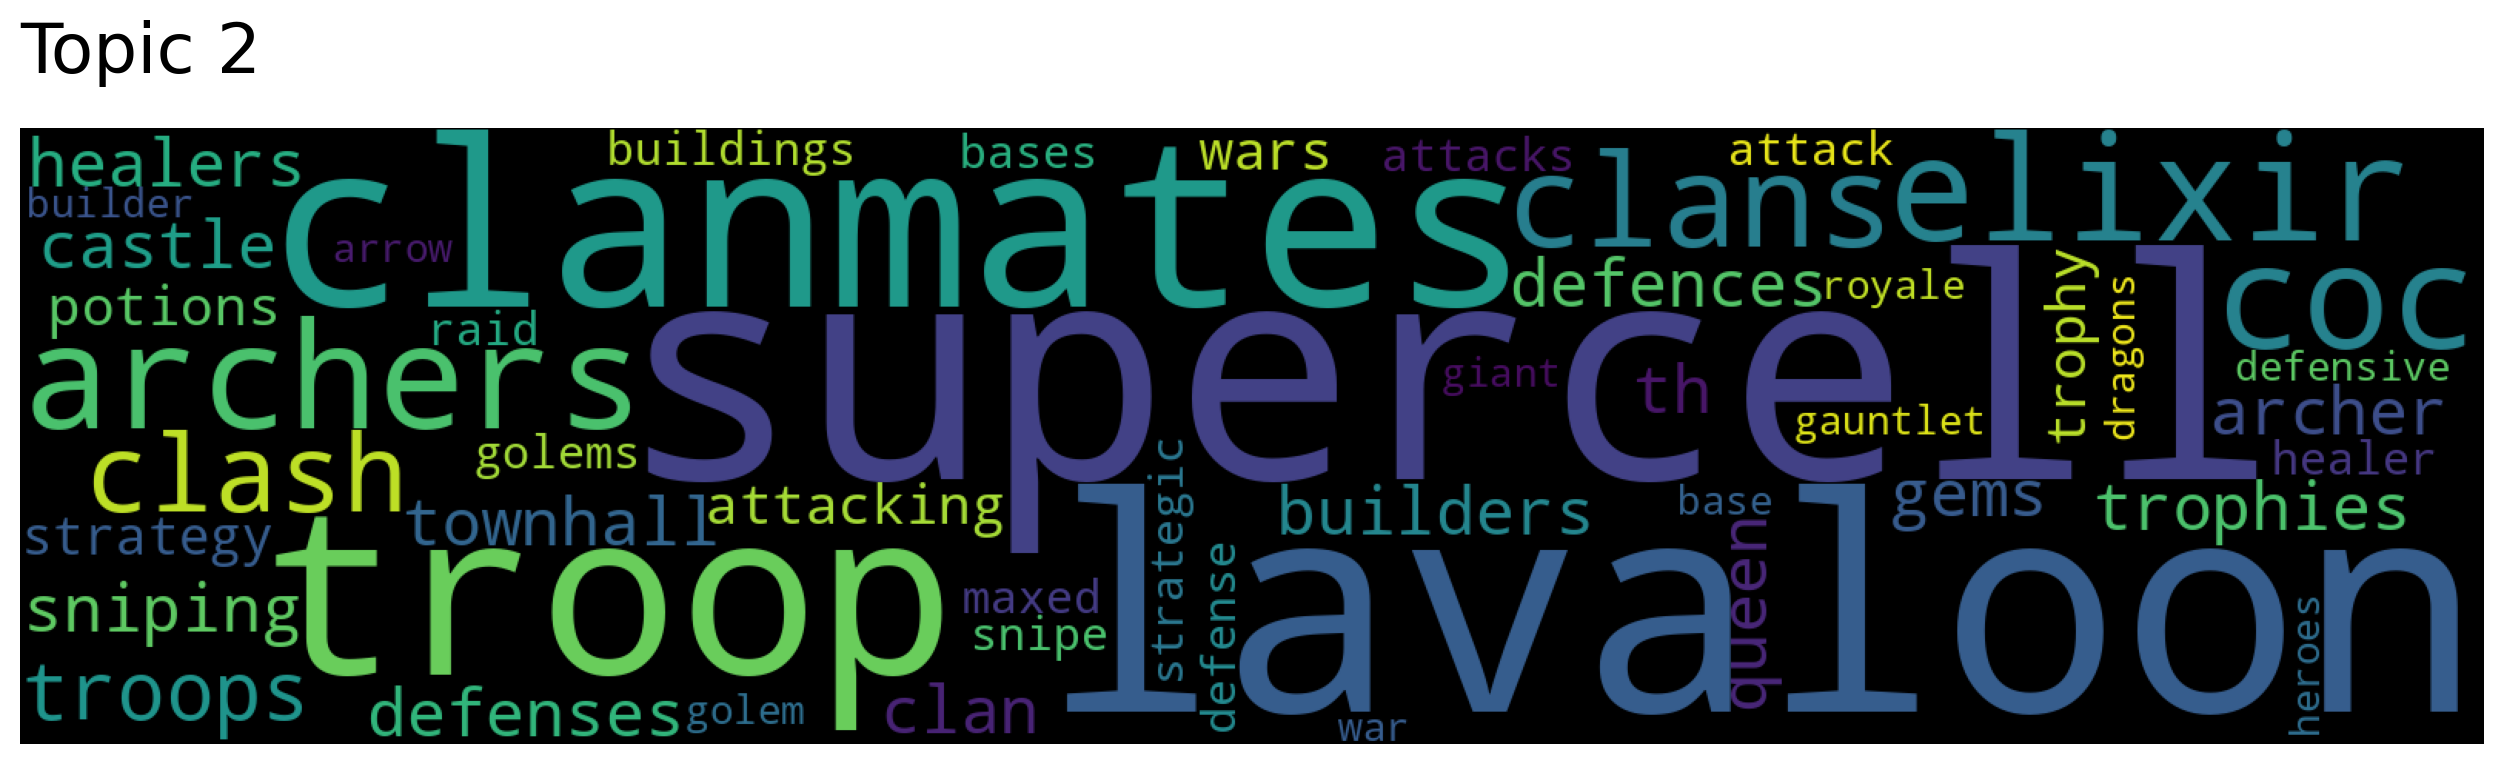

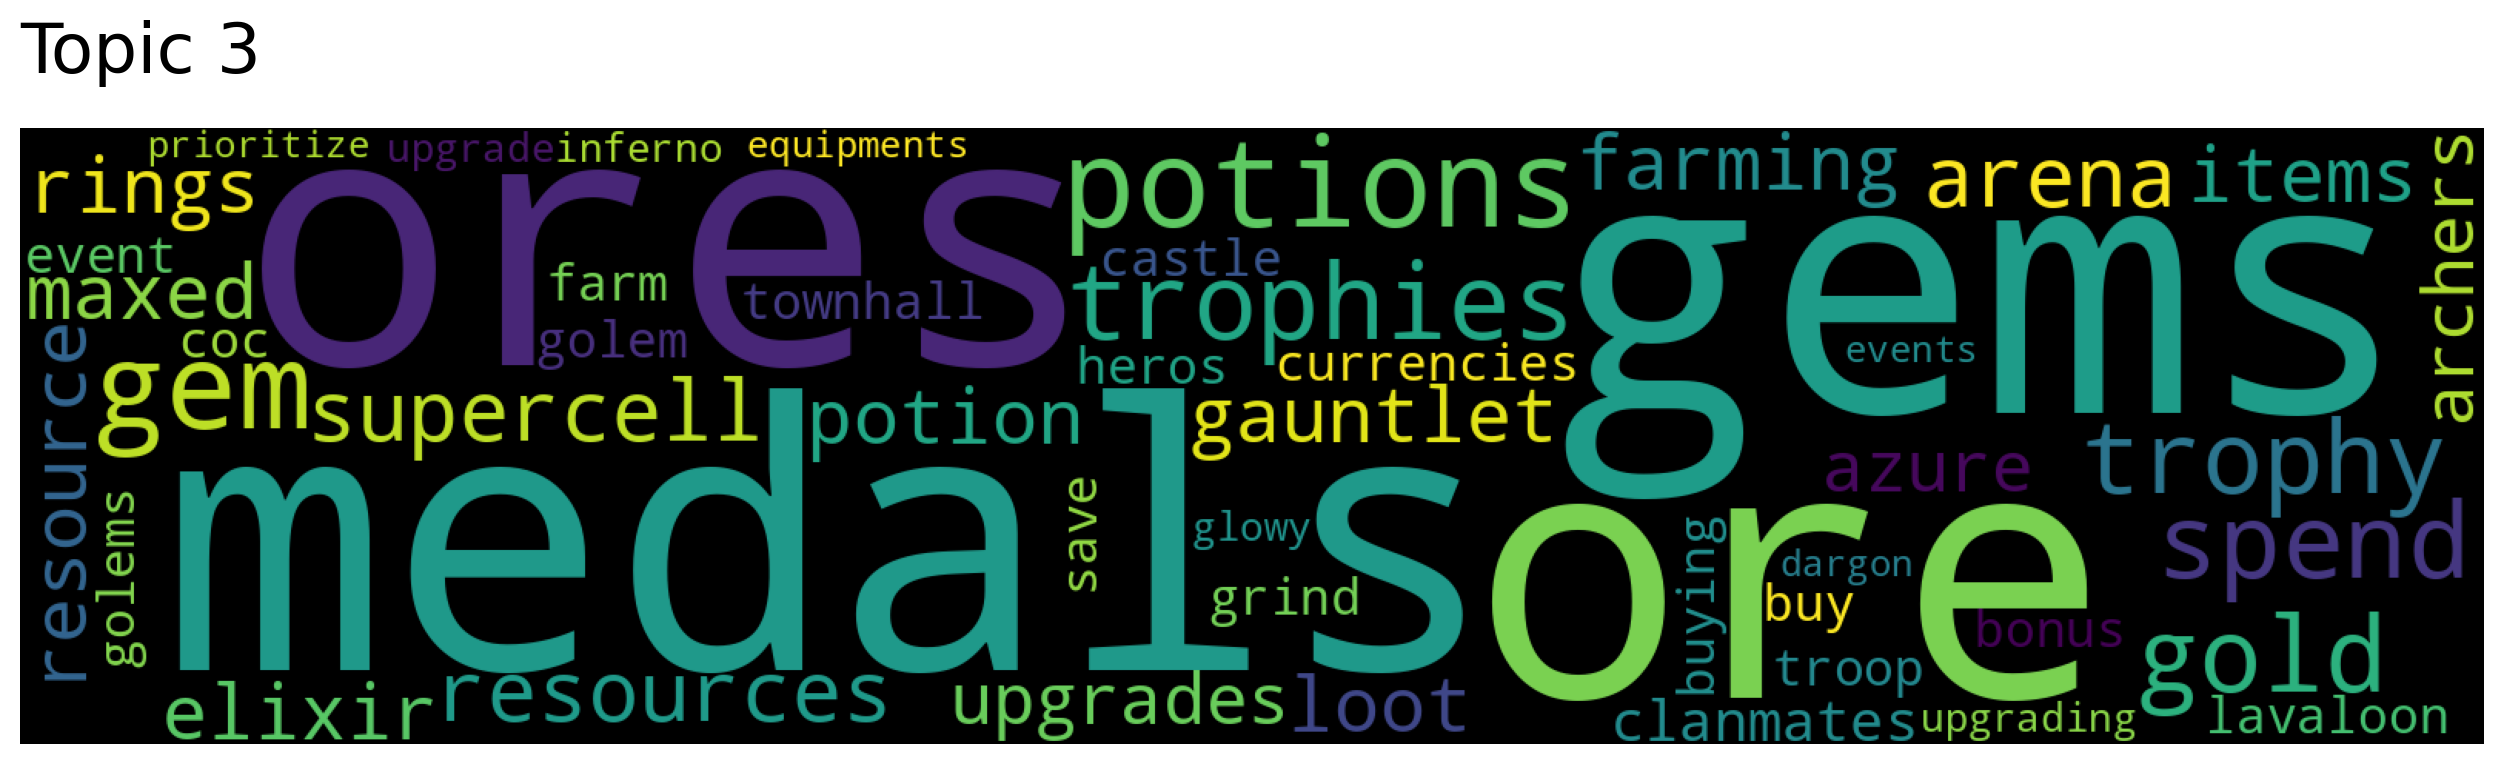

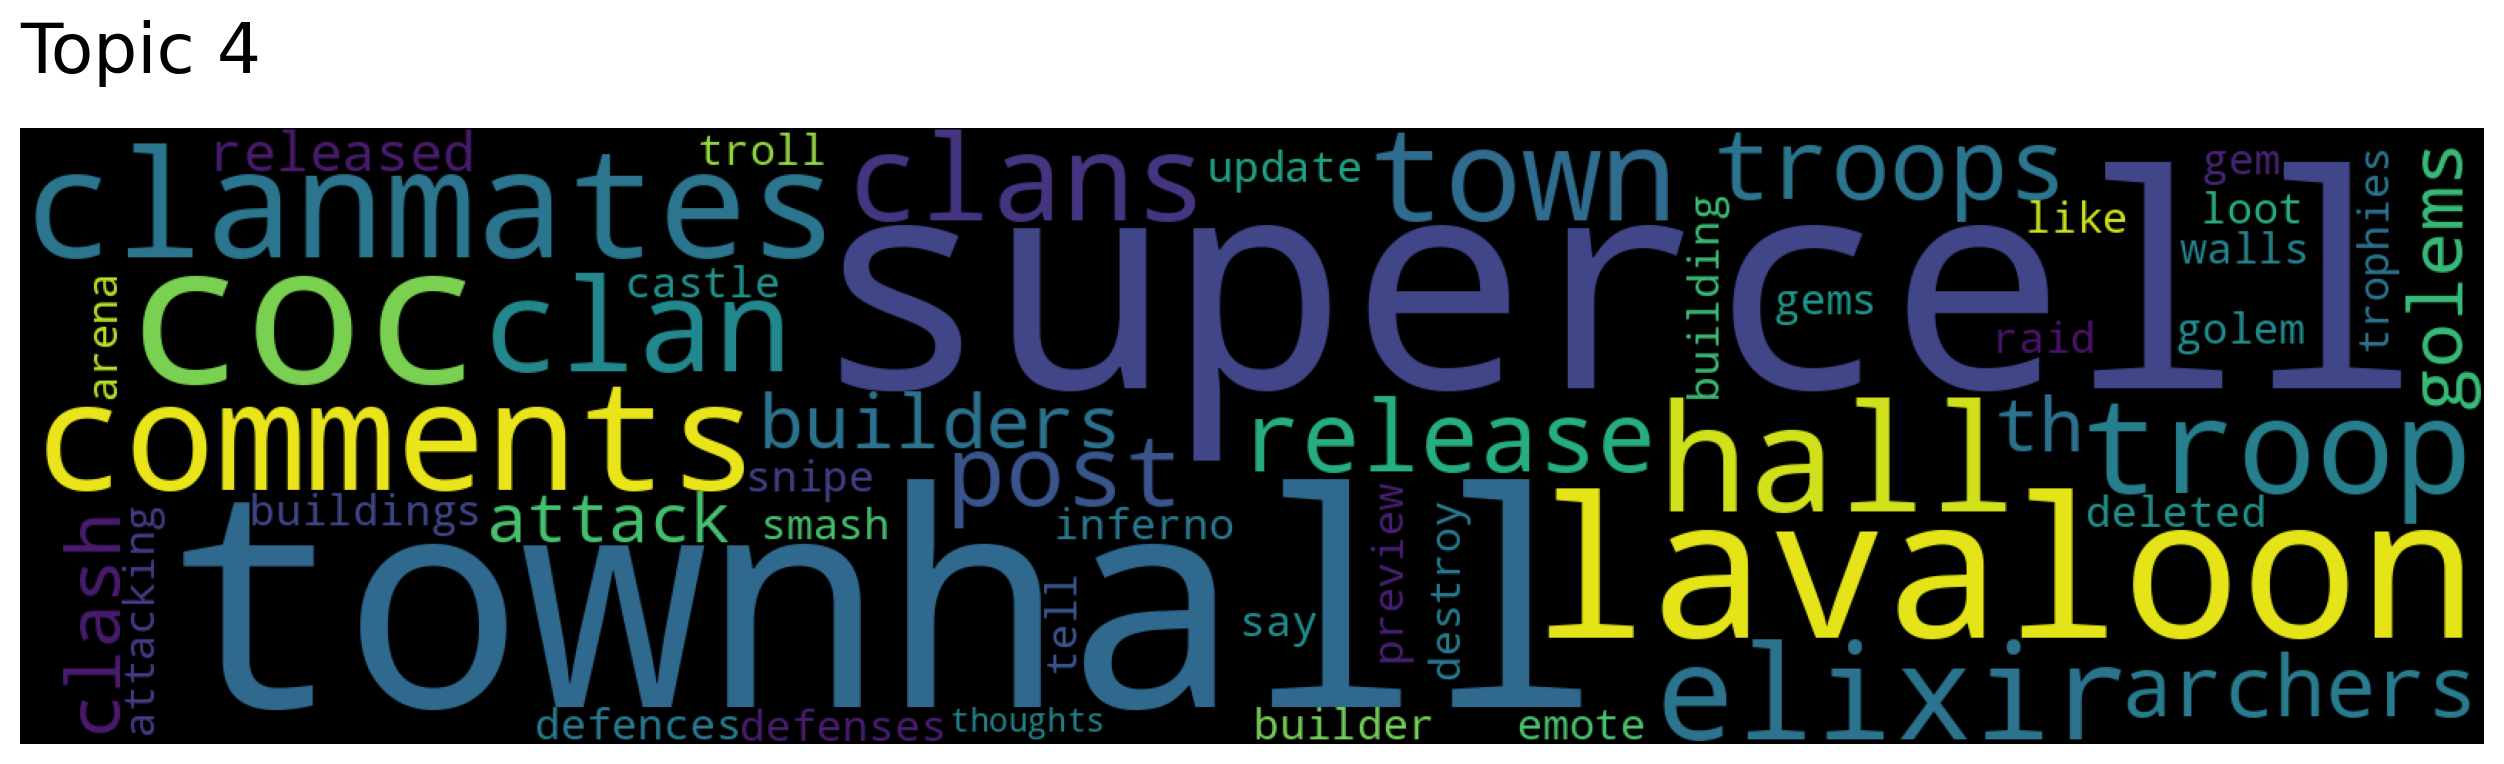

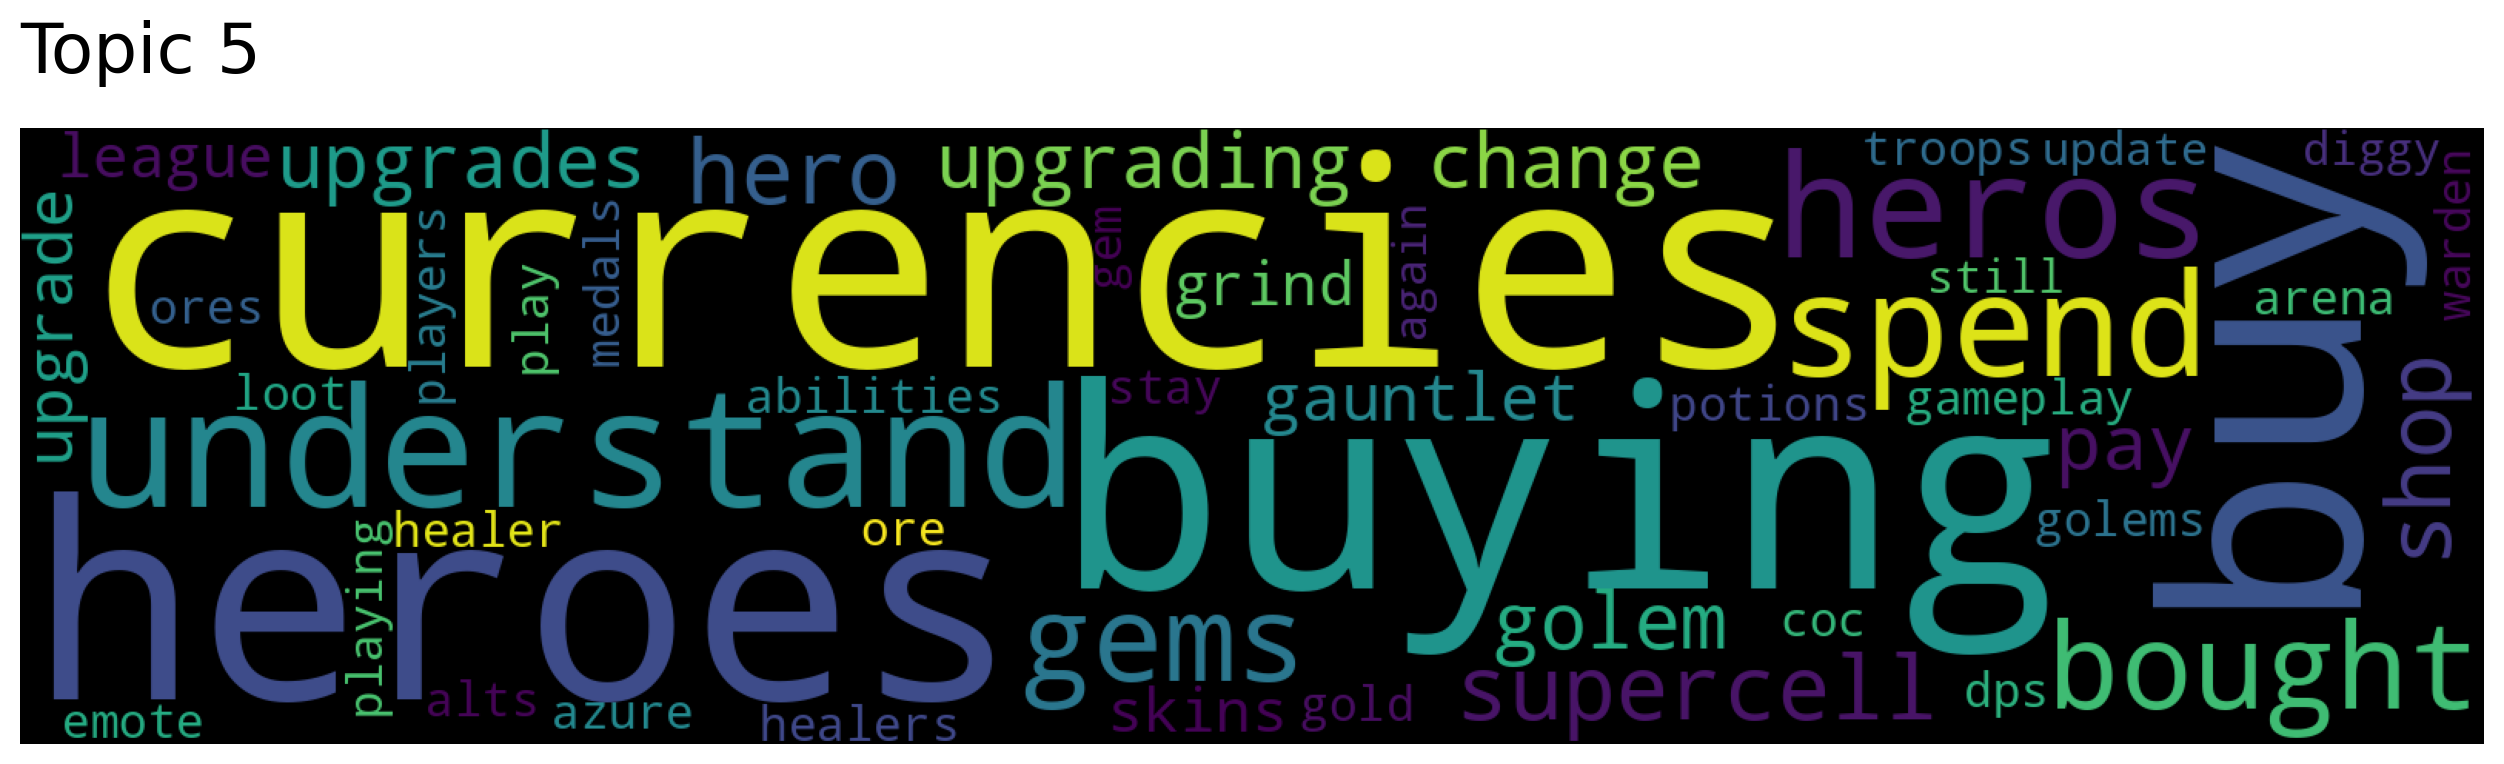

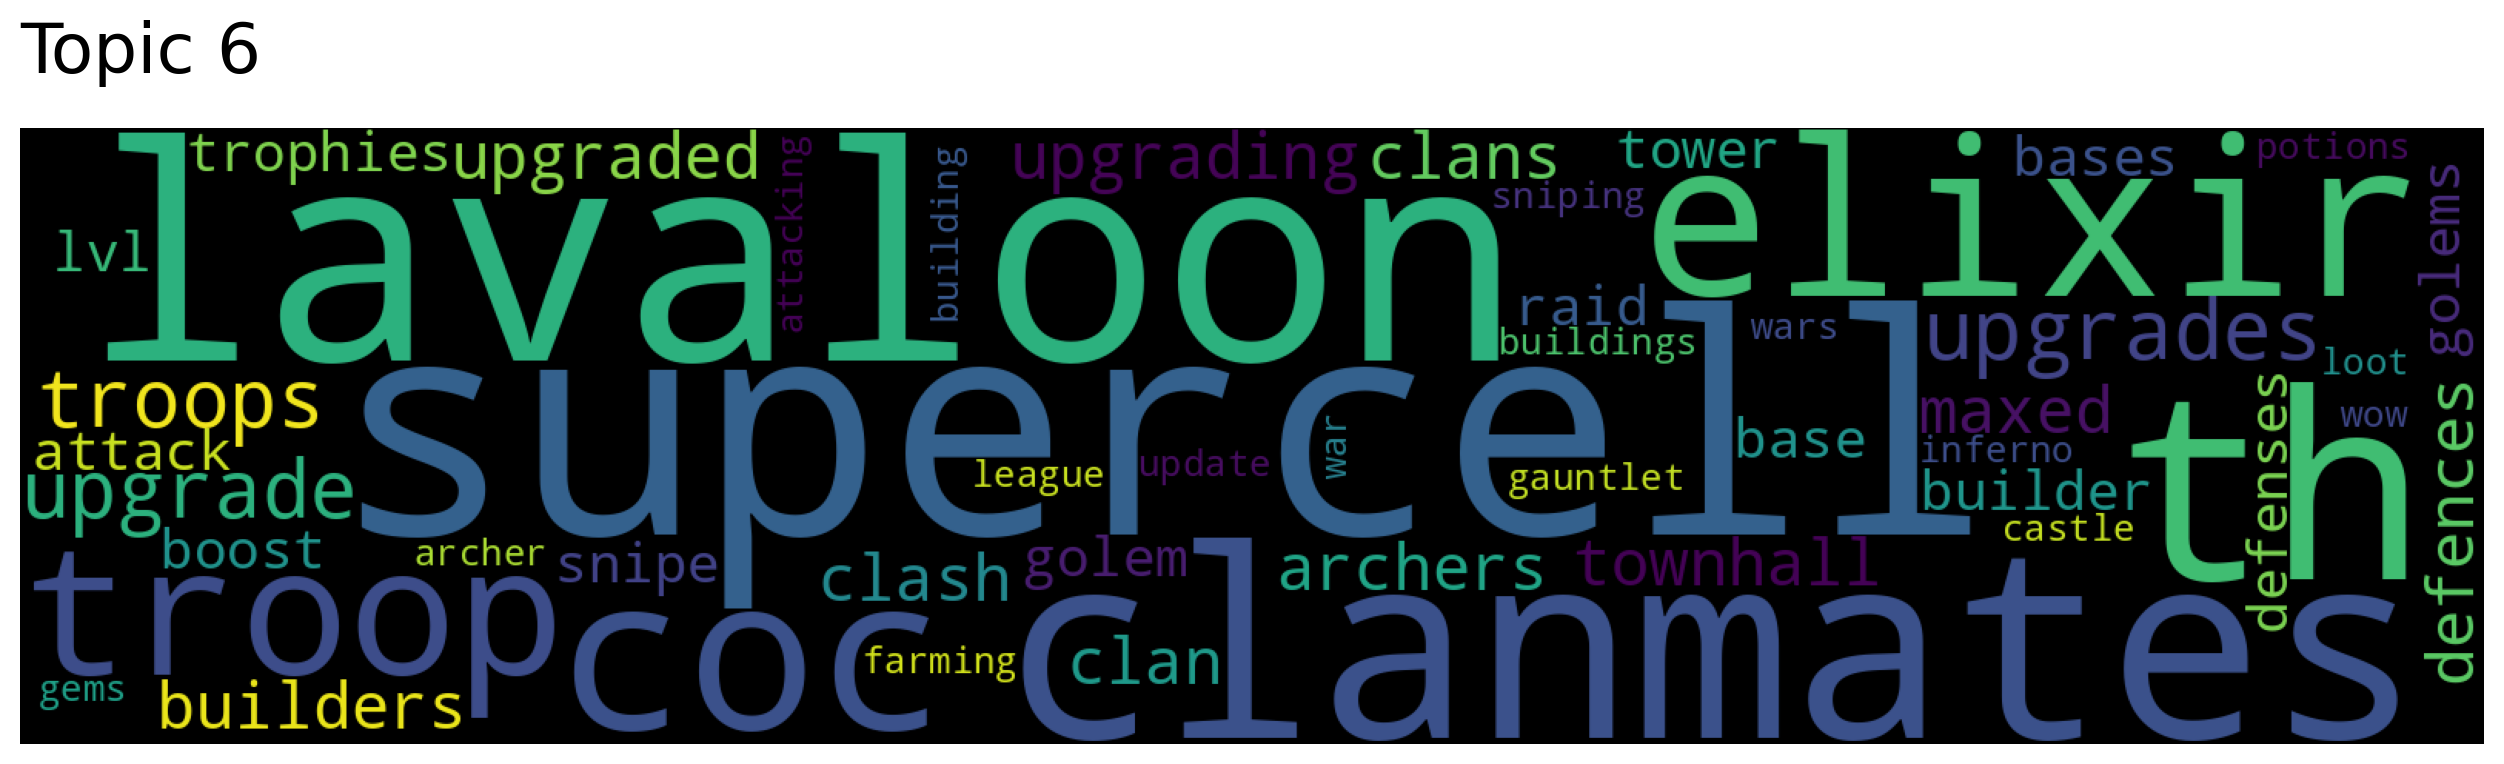

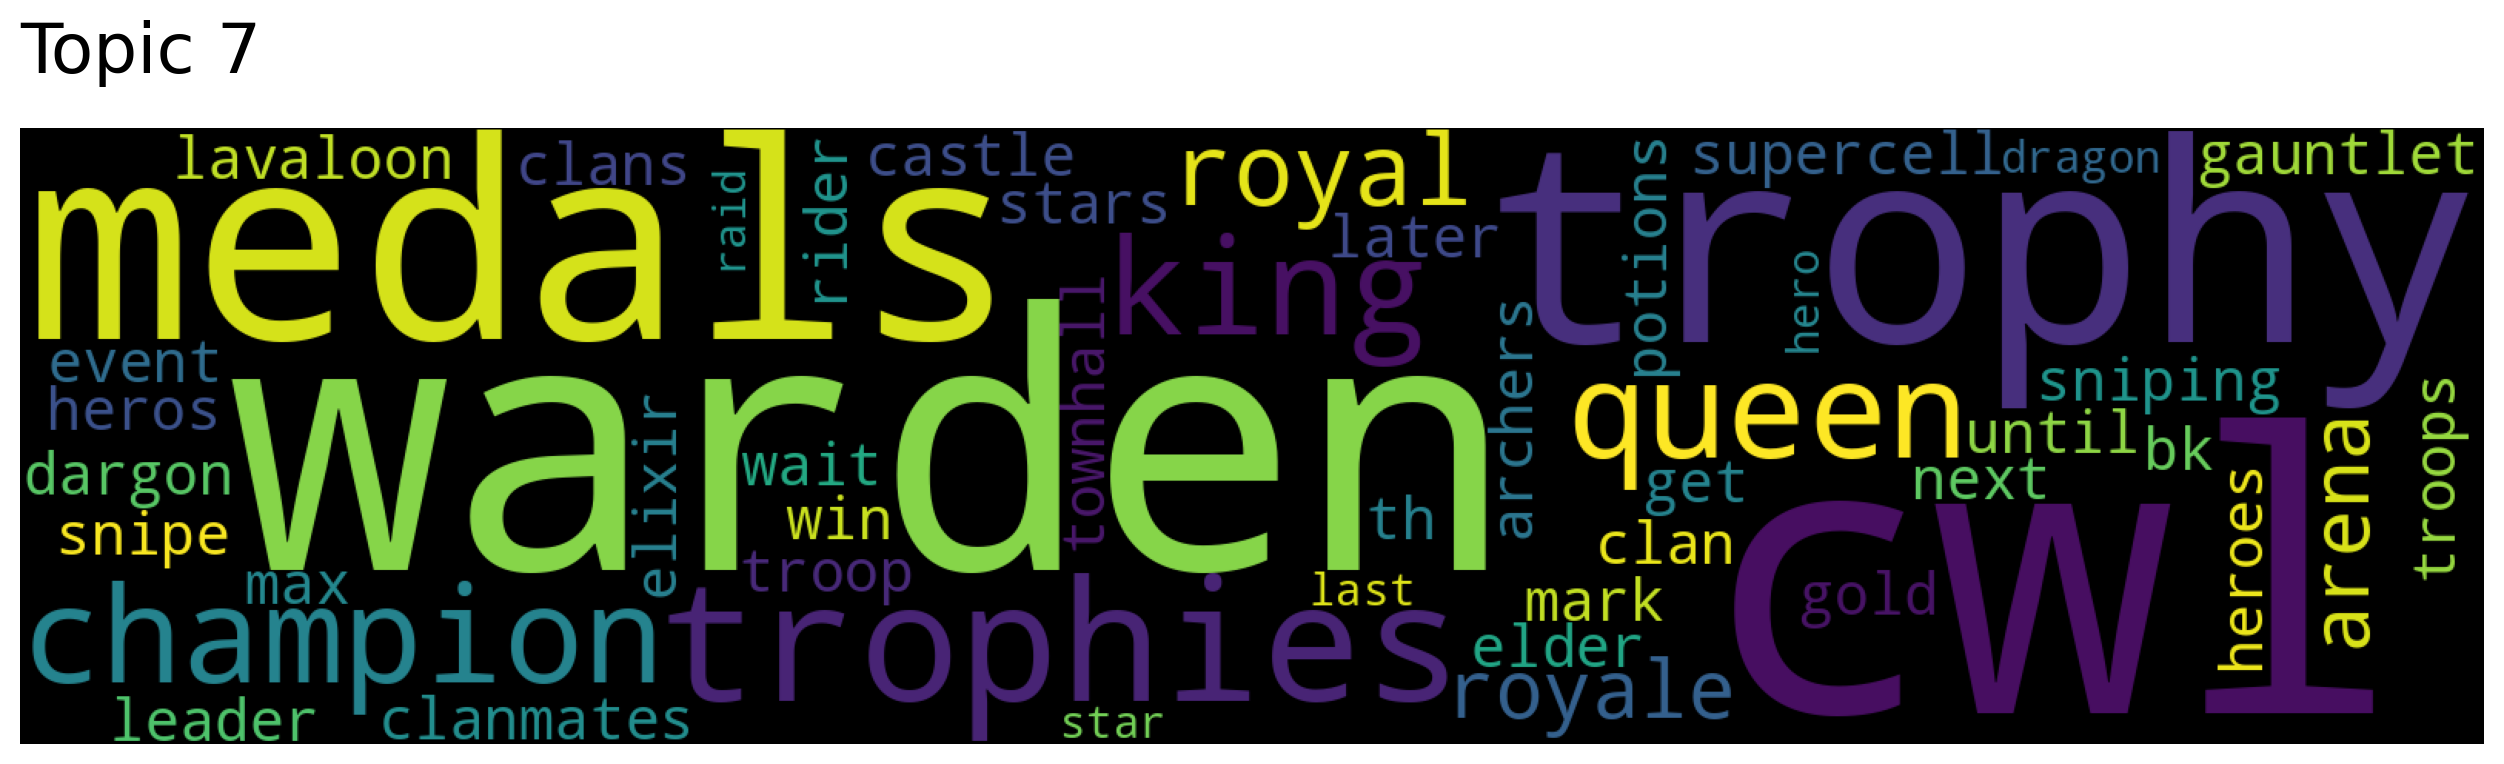

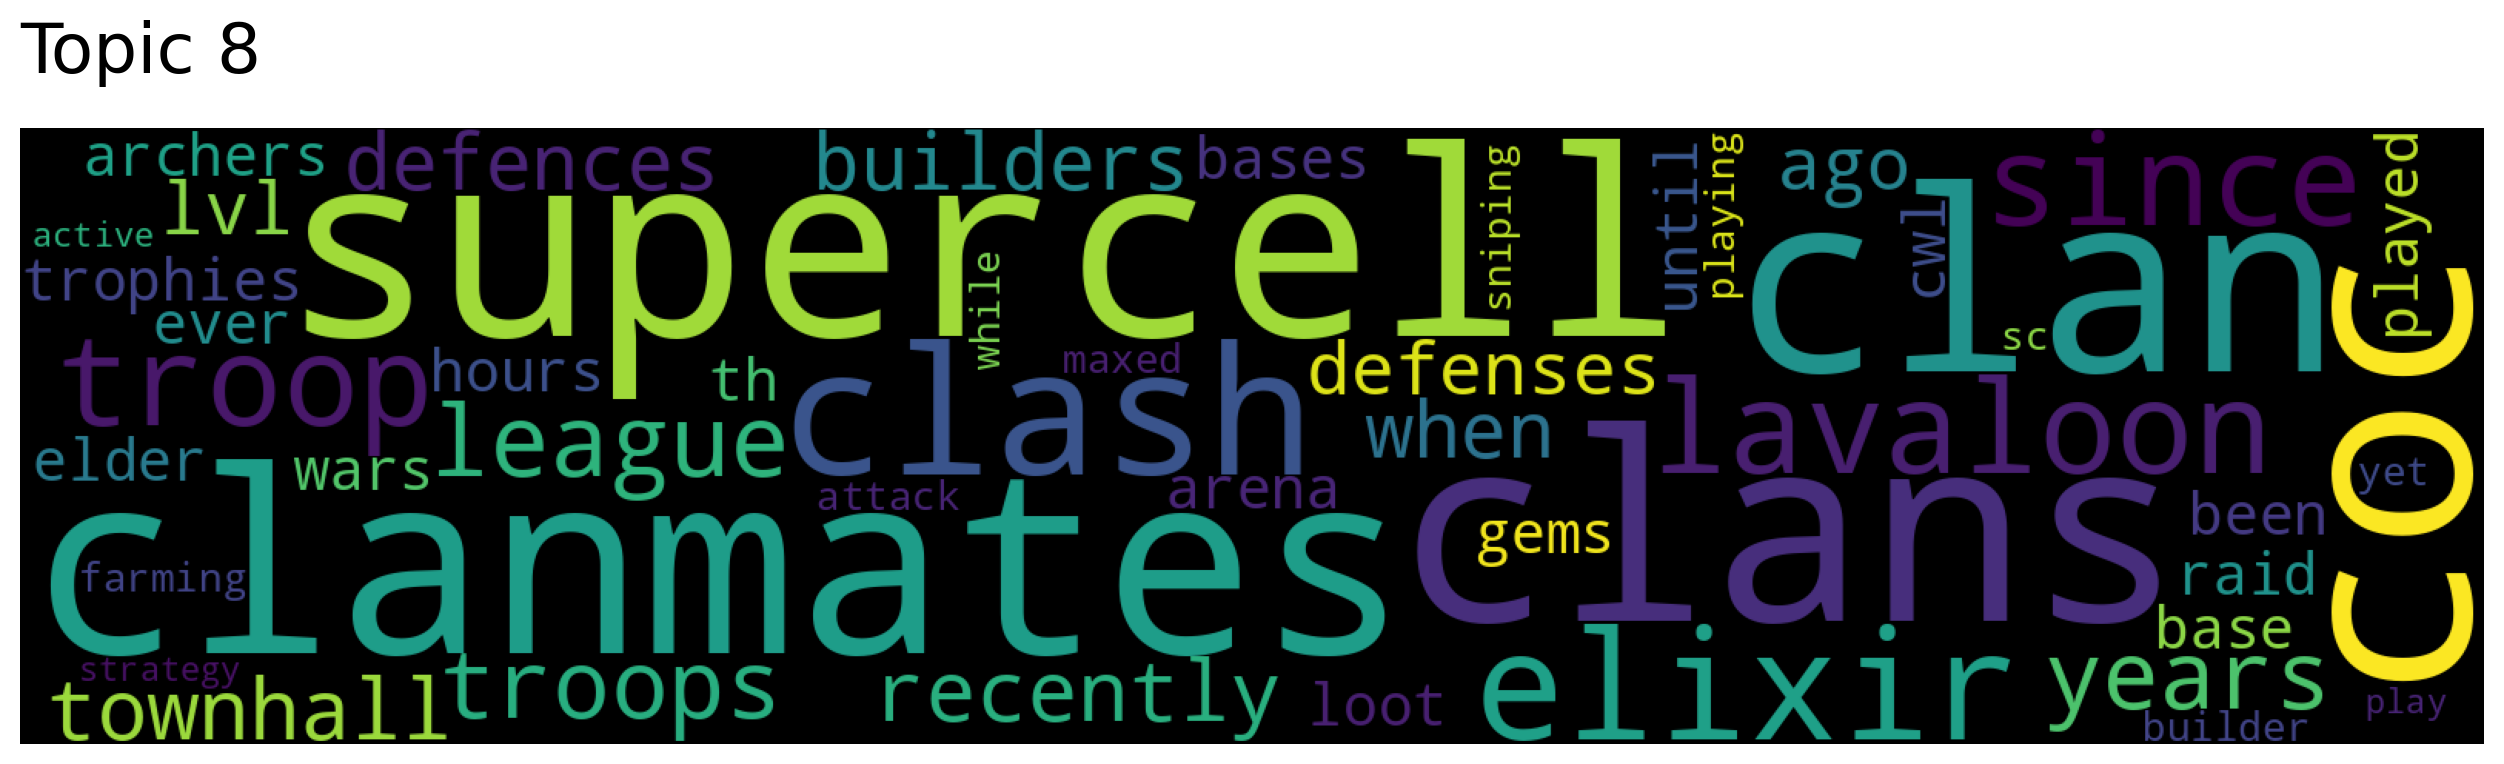

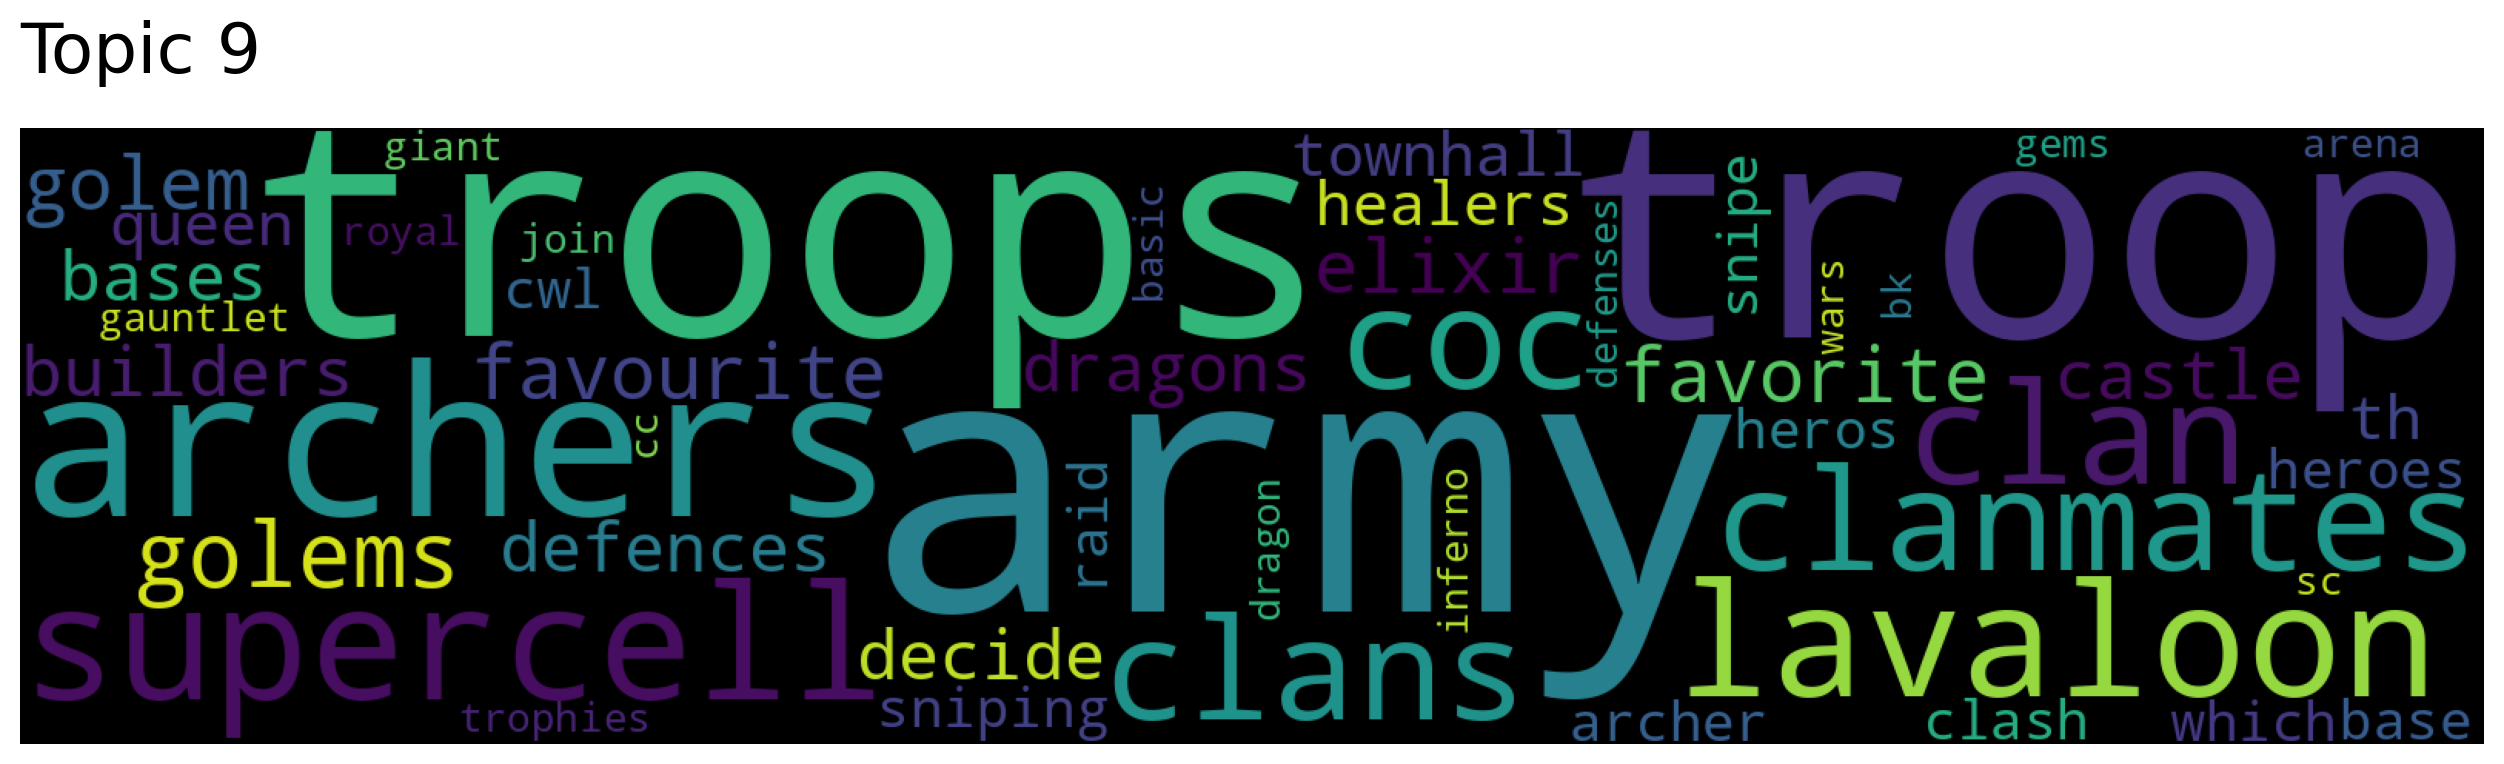

In [21]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums[:10]:
    model.generate_topic_wordcloud(topic)

# Searching

## Searching topics

In [108]:
topics_words, word_scores, topic_scores, topic_nums = model.search_topics(['bug'], 5, keywords_neg=None, reduced=False)
for words, scores, topic_score, num in zip(topics_words, word_scores, topic_scores, topic_nums):
    print(f"Document: {num}, Score: {topic_score}")
    print("-----------")
    print(words)
    print("-----------")
    print()

Document: 19, Score: 0.26243813860449583
-----------
['skin' 'skins' 'halloween' 'glowy' 'heros' 'hero' 'heroes' 'poison' 'ass'
 'shield' 'mine' 'star' 'damn' 'redd' 'rouge' 'potion' 'com' 'dude'
 'potions' 'kinda' 'golem' 'vampstash' 'my' 'favorite' 'legend' 'dragon'
 'lol' 'shiny' 'hate' 'colors' 'shit' 'favourite' 'lalo' 'vile' 'dont'
 'cookie' 'red' 'hit' 'iconic' 'legends' 'frost' 'pretty' 'pet' 'annoying'
 'spells' 'suck' 'champion' 'cuz' 'cool' 'goblins']
-----------

Document: 35, Score: 0.26226686421448797
-----------
['base' 'bases' 'defences' 'defenses' 'level' 'defense' 'tier' 'defensive'
 'attacking' 'attack' 'levels' 'lowest' 'gameplay' 'battle' 'game'
 'strategy' 'gif' 'bad' 'downside' 'issue' 'maxed' 'attacker' 'attacks'
 'strategies' 'raid' 'promoted' 'attacked' 'low' 'problem' 'wont'
 'gauntlet' 'grind' 'boost' 'top' 'harder' 'players' 'lower' 'stat'
 'fellas' 'how' 'kick' 'gw' 'abilities' 'cuz' 'drop' 'img' 'strong' 'suck'
 'strategic' 'win']
-----------

Document: 6

## Searching documents

### By topic

In [106]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=6, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 703, Score: 0.9261875152587891
-----------
Just hit TH 14 and wow the upgrade times  Haha wait till you hit 15 days
-----------

Document: 761, Score: 0.9197417497634888
-----------
Just hit TH 14 and wow the upgrade times  Just wait till U get to 16
-----------

Document: 713, Score: 0.9153916239738464
-----------
Just hit TH 14 and wow the upgrade times  Just wait for the th 16.....
-----------

Document: 688, Score: 0.9142849445343018
-----------
Just hit TH 14 and wow the upgrade times  Wait till you're th16
-----------

Document: 737, Score: 0.907296359539032
-----------
Just hit TH 14 and wow the upgrade times  #WOW#
-----------



In [103]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["bug"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 5414, Score: 0.5134907025056956
-----------
Break round? seems like a bug tbh https://www.reddit.com/r/ClashOfClans/s/ZPHKIC4w14 It's definitely a bug and not a feature
-----------

Document: 5409, Score: 0.45519470228943626
-----------
Break round? seems like a bug tbh “Seems like a bug tbh” 

Probably the best designed “bug” I’ve ever seen. Has its own text box, display and timer that somebody coded.
It is not uncommon for contingencies to be designed in case of a bug. 

His CWL having a break round is probably due to an expected odd number of clans or something, but a bug could be involved…
Nah code does that sometimes, trust me bro
the reason i thought that was a bug is because the game said that the break round was on day 6 and after pressing any button the game just crashes
It's gotta be a bug then. I, and probably most, didn't realise you were on "day 6" and thought you had one of the 5 selected. Probably just has to do with the short season this month, pretty interest